# WASP RL - Meeting 2 - Lab assignment on NAF  and SQL

In this lab we implement and experiment with NAF and SQL, both algorithms we learned about in the course and both can deal with continuous state **and** action spaces. Both algorithms employ deep neural networks for function approximation. To do this assignment, you will need to work with PyTorch, a popular framework for developing neural networks. When forming groups, make sure that at least one group member if comfortable with PyTorch and its most common tensor operations.

This notebook has been created specifically for this course and this session by *Finn Rietz* and *Johannes A. Stork*, we hope you enjoy the lab :)

In [ ]:
# install requirements if needed
import sys
!{sys.executable} -m pip install gym[classic_control]==0.26.2 numpy==1.23.0 matplotlib==3.1.2 
!{sys.executable} -m pip install torch==1.12.0 torchaudio==0.12.0 torchvision==0.13.0 scipy==1.3.3

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kde
import random
%matplotlib inline
plt.rcParams['figure.dpi'] = 100

import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
from torch.optim import Adam

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device("cpu")
print(f"torch device: {DEVICE}")

from buffer import ReplayBuffer
from utils import presample_env, transform_action, smooth, obs_transform, OUNoise, rbf_kernel2
from env_v2 import MultiGoalEnv
from network import MLP
from plotting import plot_loss, plot_reward

torch device: cuda


In [2]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

# NAF
We start with NAF. From the paper, we know that the value $V(\mathbf{x} | \theta)$, the action $\mathbf{\mu(x|}\theta)$, and the matrix entries $\mathbf{L(x}|\theta)$ are being approximated by neural networks. Its easiest to just have one a single neural network with multiple output heads for each quantity. As a first step, **adjust the code below so that the network outputs the desired values**. This involves making output layers for each quantity and implementing the equations for $Q(x,u)|\theta)$ and $A(x, u |\theta)$ in the forward pass of the neural network:
![NAF quantities](notebook_imgs/NAF_quantities.png)

In [13]:
class NAFNetwork(nn.Module):
    def __init__(self, state_size, action_size, layer_size, adapt_noise=False):
        super(NAFNetwork, self).__init__()
        self.action_size = action_size

        self.fc_0 = nn.Linear(state_size, layer_size)
        self.fc_1 = nn.Linear(layer_size, layer_size)
        self.fc_2 = nn.Linear(layer_size, layer_size)
        
        # TODO: make output layers
        # HINT: The number of entries in a (not-strictly) lower-triangular n x n matrix is: n * (n + 1) / 2
        # n : number of actions
        self.mu_head = nn.Linear(layer_size,action_size)
        self.v_head = nn.Linear(layer_size,1)
        self.mat_head = nn.Linear(layer_size,int((action_size + 1)* action_size/2))
        self.adapt_noise = adapt_noise
        if self.adapt_noise:
            print ("Using adaptive noise")
        print("Using new code")

    def forward(self, state, action=None):
        """
        Forward pass of Normalized Advantage Function
        Returns the noisy exploration action, Q(s, a), V(s), and the greedy, non-noisy action
        """
        # get latent representation
        x = torch.relu(self.fc_0(state))
        x = torch.relu(self.fc_1(x))
        x = torch.relu(self.fc_2(x))
        
        # TODO: predict the action mu, the value v and the matrix entries
        greedy_action = self.mu_head (x)
        # a neural network that separately outputs a value function term V(x)
        V = self.v_head(x)
        # the advantage function term A(x, a) is from action_diff @ P @ action_diff, where the matrix entries in P are parametrized by a neural network
        mat_head = self.mat_head(x)
        lower_triangular_entries = torch.tanh(mat_head)

        greedy_action = greedy_action.unsqueeze(-1)
        
        # TODO: calculate P
        # create empty lower-triangular matrix
        # init n x n matrix,
        L = torch.zeros((state.shape[0], self.action_size, self.action_size)).to(DEVICE)
        # get indices of lower-triangular entries (with diagonal) to parametrize P
        L_indices = torch.tril_indices(row=self.action_size, col=self.action_size)#, offset=0)
        # fill lower-triangular matrix with entries x
        L[:, L_indices[0], L_indices[1]] = lower_triangular_entries
        # with the diagonal terms exponentiated.
        L.diagonal(dim1=1, dim2=2).exp_()  # make diagonal entries positive
        # calculate P, P(x_j) = L(x_j)L(x_j)T, P is a state-dependent, positive-definite matrix
        P = L @ L.transpose(2, 1)  # P = LL^T
        
        # if an action is given (during batch update), calculate Q
        Q = None
        if action is not None:
            # calculate Advantage:
            # print ("greedy_action",greedy_action.shape)
            # print ("action.unsqueeze(-1)",action.unsqueeze(-1).shape)
            if (greedy_action.shape == action.unsqueeze(-1).shape):
                action_diff = (action.unsqueeze(-1) - greedy_action)
            else: # for new env
                action_diff = (action - greedy_action)
            #print ("shape of P: ", P.shape)
            #print ("shape of action_diff: ", action_diff.shape)
            A = -0.5 * (action_diff.transpose(2, 1) @ P @ action_diff).squeeze(-1)  # Advantage
            Q = A + V


        # add noise to the greedy action, for exploration in continuous action space
        # Initialize a random process for action exploration
        # TODO: size of noise is (batch_size, action_dim)?
        if not self.adapt_noise:
            noisy_action = greedy_action.squeeze(-1) + 0.1 * torch.randn_like(greedy_action.squeeze(-1)) 
            noisy_action = torch.clamp(noisy_action, min = -2, max = 2)


        # try with adpative noise
        else: 
            if self.training:
                noise_dist = MultivariateNormal(greedy_action.squeeze(-1), torch.inverse(P))  
                noisy_action = noise_dist.sample()
                noisy_action = torch.clamp(noisy_action, min = -2, max = 2)
            else:
                noisy_action = greedy_action
        
        return noisy_action, Q, V, greedy_action

Next, we make a class for the NAF agent, that will hold an instance of the above class for the neural network. The agent also implements an update method that updates the parameters of the neural network networka and a rollout method. Fortunately, the NAF update is straightforward, since it directly minimizes the TD error. **In the below cell, in the `update` method, compute the loss as described in the algorithm**. The update method alongside the rollout method essentially implement the entire NAF algorithm:
![NAF algorithm](notebook_imgs/NAF_algo.png)

In [14]:
class NAFAgent:
    def __init__(self, n_states, n_actions, buffer, net_size, gamma, tau, lr, adapt_noise=False):
        """
        @param n_states: The dimensionality of the state space
        @param n_actions: The dimensionality of the action space
        @param buffer: An instance of a replay buffer
        @param net_size: The width of the NAF network layers
        @param gamma: The discount rate
        @param tau: The soft/polyak target network update rate
        @param lr: The learning rate
        """
        self.buffer = buffer
        self.loss_fn = nn.SmoothL1Loss()
        self.update_counter = 0
        self.GAMMA = gamma
        self.TAU = tau
        self.LR = lr
        self.loss_hist = []
        self.adapt_noise = adapt_noise

        # main network
        self.naf_net = NAFNetwork(
            state_size=n_states,
            action_size=n_actions,
            layer_size=net_size,
            adapt_noise= self.adapt_noise
        )
        self.naf_net.to(DEVICE)

        # target network
        self.target_net = NAFNetwork(
            state_size=n_states,
            action_size=n_actions,
            layer_size=net_size,
            adapt_noise= self.adapt_noise
         )
        self.target_net.to(DEVICE)
        self.target_net.load_state_dict(self.naf_net.state_dict())

        self.optim = Adam(self.naf_net.parameters(), lr=self.LR)
        
    def rollout(self, env, episode, mode="train"):
        """
        Runs one episode and does a batch update after each step.
        """
        obs, info = env.reset()
        done = False
        truncated = False
        total_reward = 0
        
        def ensure_np_array(var):
            if not isinstance(var, np.ndarray):
                var = np.array(var)
            return var
        
        while not (done or truncated):
            if mode == "train":
                action, _, _, _ = self.naf_net(torch.from_numpy(obs).unsqueeze(0).to(DEVICE).to(torch.float32))
            elif mode == "eval":
                _, _, _, action = self.naf_net(torch.from_numpy(obs).to(DEVICE).to(torch.float32))
            else:
                raise ValueError(f"Invalid mode 'mode' given!")
            
            action = transform_action(action.squeeze(0), env)
            # fix code: only works for Pendulum environment
            # action = ensure_np_array(action)
            
            new_obs, reward, done, truncated, info = env.step(action)
            total_reward += reward
            
            if mode == "train":
                self.buffer.add(obs, action, reward, new_obs, done)
                self.update()

            if done or truncated:
                print(f"Total reward {mode} episode {episode}: {total_reward}")
                return total_reward
            
            obs = new_obs

    def update(self):
        """
        Updates the neural network based on a batch of experiences sampled from the replay buffer.
        """
        if len(self.buffer) < self.buffer.batch_size:
            return

        states, actions, rewards, next_states, dones = self.buffer.sample()
        self.optim.zero_grad()
        
        # TODO: compute the loss
        # This involves calling self.loss_fn(Q, y)
        # ---------------------
        
        # Calculate predicted Q values and target Q values
        _, predicted_q_values, _, _ = self.naf_net(states, actions)
        # print ("next_states: ", next_states.shape)
        # print  ("next_states: ", next_states)
        _, _, _, next_actions = self.naf_net(next_states)
        # print ("next_actions: ", next_actions.shape)
        # print ("next_actions: ", next_actions)
        _, _, next_values, _ = self.target_net(next_states, next_actions)
        target_q_values = rewards + self.GAMMA * next_values * (1 - dones)

        loss = self.loss_fn(predicted_q_values, target_q_values)


                
        # ---------------------
        loss.backward()
        self.optim.step()

        self.loss_hist.append(loss.item())
        self.update_counter += 1

        # polyak/soft target network udpate
        for target_param, current_param in zip(self.target_net.parameters(), self.naf_net.parameters()):
            target_param.data.copy_(self.TAU * current_param.data + (1.0 - self.TAU) * target_param.data)

Now, we just need a method that initializes the agent and runs the main trianing loop . **In the next cell, don't change anything**. You can play with the hyperparameters later, but when we highly recommend that you don't change them for now, since the ones we put for you definitly work!

In [15]:
def naf_algo(env, adapt_noise=False): 
    # hyperparameters
    TRAIN_EPISODES = 200
    NET_SIZE = 64
    GAMMA = 0.975
    TAU = 0.0025
    LR = 0.001
    BATCH_SIZE = 128
    
    buffer = ReplayBuffer(
        buffer_size=int(1e6),
        batch_size=BATCH_SIZE,
        device=DEVICE,
    )
    
    agent = NAFAgent(
        env.observation_space.shape[0],
        env.action_space.shape[0],
        buffer,
        NET_SIZE,
        GAMMA,
        TAU,
        LR,
        adapt_noise=adapt_noise
    )
    
    # populate replay buffer with 10k random transitions
    presample_env(env, agent.buffer, 10000)

    # main loop
    training_rewards = []
    eval_rewards = []
    eval_eps = []
    for episode in range(TRAIN_EPISODES):
        tr = agent.rollout(env, episode)
        training_rewards.append(tr)

        if episode % 5 == 0:
            er = agent.rollout(env, episode, mode="eval")
            eval_rewards.append(er)
            eval_eps.append(episode)
            
    plot_loss(agent.loss_hist)
    plot_reward(training_rewards, eval_rewards, eval_eps)
    
    return agent

# Testing NAF on Pendulum environment
Now, with all of this (partially boilerplate) code out of the way, its time to test our NAF agent. We use the [OpenAI Gym Pendulum environment](https://mgoulao.github.io/gym-docs/environments/classic_control/pendulum/), which is arguably one of the easiest, continuous action space environments. The agent should reach about -250 reward relatively quickly, if you've implemented everything correctly. There can still be quite some variation (i.e. between 0 and -700), depending on the random initialization of the pendulum...

Using new code
Using new code
Presampling done
Total reward train episode 0: -1667.135861688209
Total reward eval episode 0: -1273.9468643222954
Total reward train episode 1: -1044.2697194838001
Total reward train episode 2: -1520.2934600298966
Total reward train episode 3: -1642.9054153475163
Total reward train episode 4: -1627.8942166780726
Total reward train episode 5: -1699.7352073425873
Total reward eval episode 5: -1546.8322710723007
Total reward train episode 6: -1598.8687414810795
Total reward train episode 7: -1626.2498808797534
Total reward train episode 8: -1627.1670575136764
Total reward train episode 9: -1425.2758165304867
Total reward train episode 10: -1357.2334206329017
Total reward eval episode 10: -1245.330626251816
Total reward train episode 11: -1373.0490810685446
Total reward train episode 12: -1295.3028468197867
Total reward train episode 13: -1099.8819636237097
Total reward train episode 14: -1492.1471943611928
Total reward train episode 15: -1160.1526538120368
T

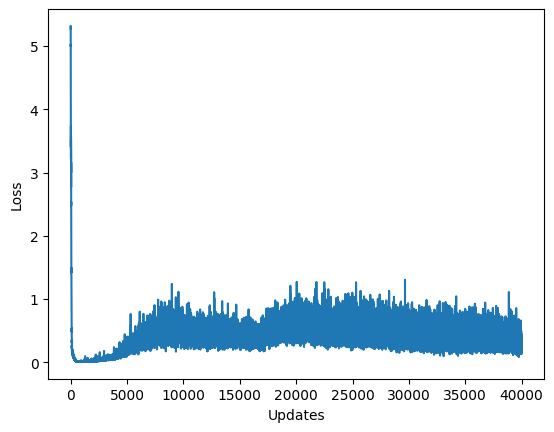

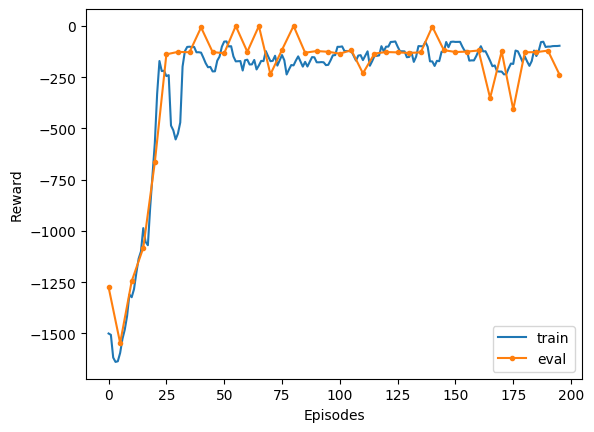

In [10]:
pendulum_env = gym.make("Pendulum-v1")
naf_agent = naf_algo(pendulum_env, adapt_noise=False)

### Continue with the next part of the assignment only when your NAF implementation maintains between 0 and -700 reward on the pendulum environment!
Once the NAF agent reaches acceptable performance on the pendulum environment, explore the effect of exploration noise. In the NAF paper in section 8.2, the authors describe how to use the matrix $P$ from the advantage term for adaptive noise generation. Assuming you used simple Gaussian noise so far, go back to the the forward pass of the neural network and implement adaptive noise instead. Do you observe a considerable difference on the Pendulum environment when using adaptive noise?

Using adaptive noise
Using new code
Using adaptive noise
Using new code
Presampling done
Total reward train episode 0: -1693.469619119097
Total reward eval episode 0: -1521.0974506694633
Total reward train episode 1: -1737.3811258377912
Total reward train episode 2: -1504.6465119531551
Total reward train episode 3: -1201.288464263378
Total reward train episode 4: -1597.3505501277707
Total reward train episode 5: -1585.6031751550565
Total reward eval episode 5: -1696.5483601443639
Total reward train episode 6: -1740.4460659846711
Total reward train episode 7: -1724.8161015829617
Total reward train episode 8: -1628.4125763945885
Total reward train episode 9: -1685.2974043987126
Total reward train episode 10: -1715.1785285828375
Total reward eval episode 10: -1649.44674149812
Total reward train episode 11: -1395.4435058120896
Total reward train episode 12: -1430.2710547316901
Total reward train episode 13: -1415.8429293956285
Total reward train episode 14: -909.8079197977335
Total reward 

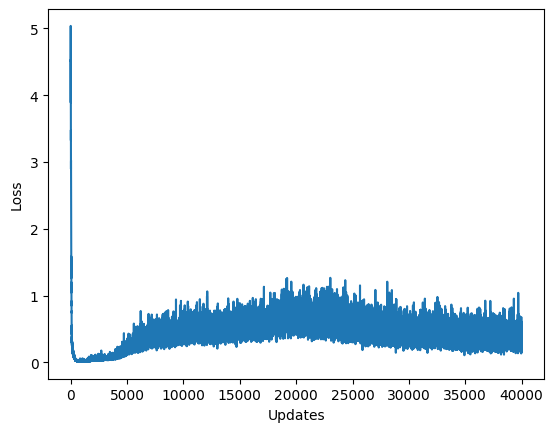

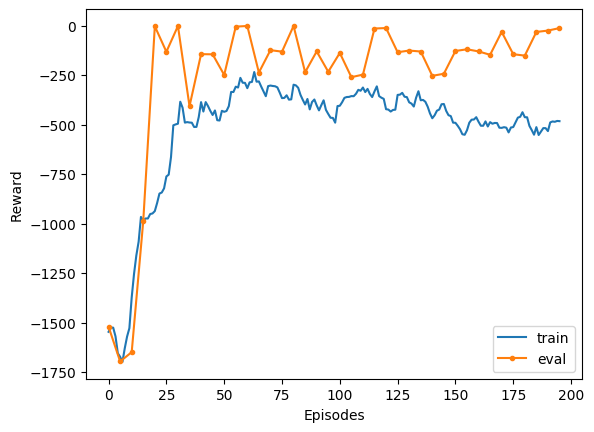

In [11]:
# try with adaptive noise
pendulum_env = gym.make("Pendulum-v1")
naf_agent = naf_algo(pendulum_env, adapt_noise=True)

# Multigoal environment
Now, we turn to a more interesting but still toy example, the "multigoal" environment introduced in the Soft Q-Learning paper. This environment features four goals (the stars in the below image) the agent can navigate to. The observation is the current position, the actions are 2D velocities to apply to the agent. The agent always starts at the center (plus some small random offset). The reward is the distance to the closest goal plus a small cost proportional to the squarred action sum. Consider below the plot of the reward function evaluated at a fine grid of locations for further intuition:
![multigoal env](notebook_imgs/multigoal-env-reward.png)

# TASK: Draw on a paper a [contour plot](https://se.mathworks.com/help/examples/graphics/win64/DisplayContourLabelsExample_01.png) of what you think NAF's value function will look like, evaluate at 2D locations in the environment as done with the reward function above. Keep the paper for later comparison with the actual value function. 

...

# TASK: Also draw the trajectories that you think NAF's policy will generate. Keep the paper for later comparison with actual trajectories generated by the policy.

...

Using new code
Using new code
Presampling done
Total reward train episode 0: -14656.7798550526
Total reward eval episode 0: -17663.377830119705
Total reward train episode 1: -7919.124631661023
Total reward train episode 2: -729.2599039758923
Total reward train episode 3: -593.1124448976856
Total reward train episode 4: -741.5086240038803
Total reward train episode 5: -552.548039129637
Total reward eval episode 5: -604.1418278208943
Total reward train episode 6: -732.4806910528665
Total reward train episode 7: -606.9191585307424
Total reward train episode 8: -619.6086800656866
Total reward train episode 9: -586.2305836177155
Total reward train episode 10: -561.2319006367317
Total reward eval episode 10: -446.3970937711704
Total reward train episode 11: -772.6539500378067
Total reward train episode 12: -646.051482994844
Total reward train episode 13: -650.3873744873176
Total reward train episode 14: -356.5203839618478
Total reward train episode 15: -434.20665300100507
Total reward eval e

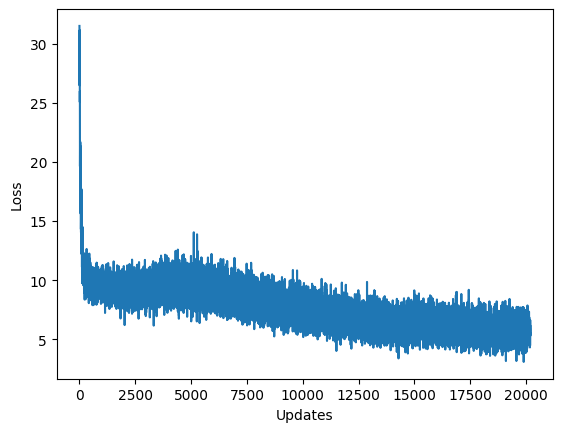

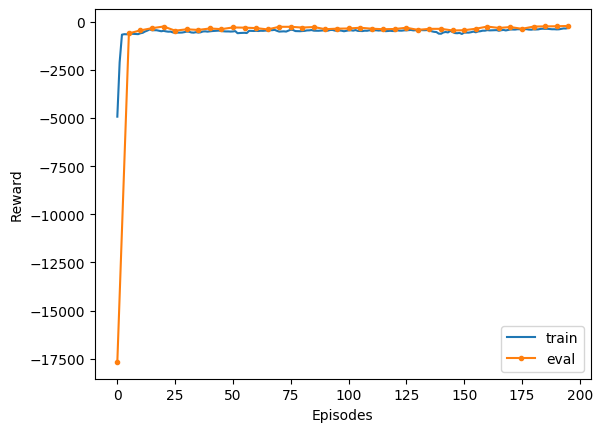

In [16]:
multigoal_env = MultiGoalEnv()
naf_agent = naf_algo(multigoal_env)

# Analyze the reward and loss plots. Explain the result.

...

# Visualizing the value function
In addition to the the loss plot and reward plot above, it can be helpfull to visualize the learned value function and or policy, to understand better what the agent learned. This is often straightforward in 2D environments, since a small 2D grid is still managable in terms of compute. As such, **visualize the value function learned by the NAF agent on the multigoal environment**. Does NAF's learned value function look similar to what you drew on the paper? Can you explain why the learned value function looks the way it does?

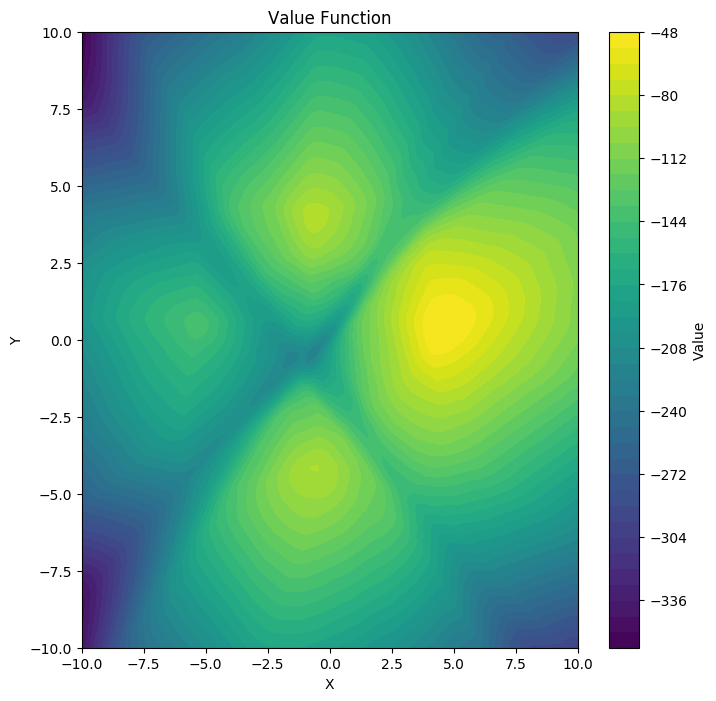

In [18]:
# Create a grid of (x, y) coordinates at which to evaluate the value function
x = np.linspace(multigoal_env.xlim[0], multigoal_env.xlim[1], 100)
y = np.linspace(multigoal_env.ylim[0], multigoal_env.ylim[1], 100)
X, Y = np.meshgrid(x, y)

# For each (x, y) pair, evaluate the value function with the NAF network
Z = np.zeros((100, 100))
for i in range(100):
    for j in range(100):
        state = torch.tensor([X[i, j], Y[i, j]], dtype=torch.float32).to(DEVICE)
        _, _, value, _ = naf_agent.naf_net(state.unsqueeze(0))
        Z[i, j] = value.item()

# Plot the value function as a contour plot
plt.figure(figsize=(8, 8))
plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(label='Value')
plt.title('Value Function')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

...

# Visualizing trajectories
In addition to the value function, we can inspect the trajectories generated by the policy. **Collect, plot and analyze some (10 - 50) trajectories from the policy**. Are the agent's trajectory similar to what you drew on the paper? Explain the result.

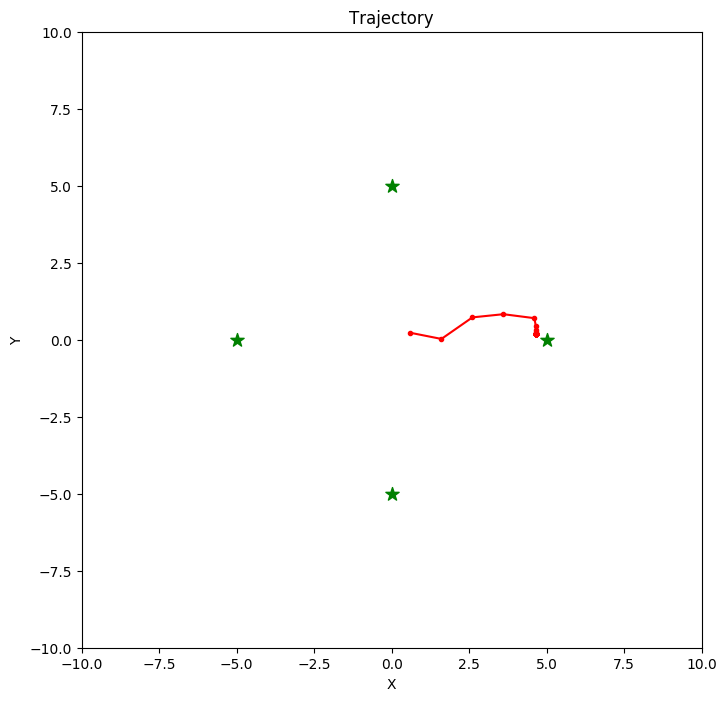

In [24]:
multigoal_env.init_sigma = 0.4  # we increase the reset noise, so we get a bit more diverse starting positions...

# YOUR CODE HERE
state, _ = multigoal_env.reset()
trajectory = [state]
# 200 steps
for _ in range(200):
    state_tensor = torch.tensor([state], dtype=torch.float32).to(DEVICE)
    _, _, _, greedy_action= naf_agent.naf_net(state_tensor)
    action = greedy_action.detach().squeeze().cpu().numpy()

    state, _, done, _, _ = multigoal_env.step(action)
    trajectory.append(state)

    if done:
        break

trajectory = np.array(trajectory)

# Plot the trajectory
plt.figure(figsize=(8, 8))
plt.plot(trajectory[:, 0], trajectory[:, 1], 'r.-')
plt.scatter(multigoal_env.goal_positions[:, 0], multigoal_env.goal_positions[:, 1], c="g", s=100, marker="*")
plt.xlim(multigoal_env.xlim)
plt.ylim(multigoal_env.ylim)
plt.title('Trajectory')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

...

# Soft Q-Learning


We now turn to the second algorithm we learned about that can deal with continuous state and action spaces: Soft Q-learning (SQL). SQL is based on two neural networks, one for the $Q$-function and one for the policy. These are plain MLPs, hence this time you don't have to implement the neural network. However, you must initialize these networks with the correct input and output sizes. Thus, **in the `init` method in the next cell, set the `q_in_size`, `q_out_size`, `asvgd_noise_size`, `pi_in_size`, and `pi_out_size` variables**. These are passed to the respective neural networks initalizations.

Further, you will implement the update of the $Q$-function approximating neural network. This is relatively straightforward and based on the TD-error. **In the next cell, in the `td_update` method, calculate the loss for the $Q$-approximating network**. For this, you need to implement and consider the following equations. The soft value function:
![sql_vsoft](notebook_imgs/SQL_v_soft.png)
The soft value function's empirical estimate:
![sql_empirical_vsoft](notebook_imgs/SQL_empirical_v_soft.png)
And the minimization objective:
![sql_JQ](notebook_imgs/SQL_jq.png)
Note, that $\hat{Q}^{\bar\theta}_{\text{soft}} = r_t + \gamma \mathbb{E}_{s_{t+1}\sim p_s}[ V^{\bar\theta}_{\text{soft}}(s_{t+1}) ]$ and that $\bar\theta$ refers to the target network parameter.

We implement the update of the policy network for you, because itrelies on a method not covered in the course, the Amortized Stein Variational Gradient Descent (ASVGD). ASVGD has gained increasing popularity in SOTA research and provides an interesting alternative to sampling methods like Markov Chain Monte Carlo or Metropolis Hastings. ASVGD moves a set of random particles such that, after convergence, they act like samples from the distribution of interest, and only requires access to the unnormalized density. You can take a look how this is implemented and how it updates the policy network in the `asvgd_update` method. If you are interested, we encourage you to take a look at the official [project website](https://www.cs.utexas.edu/~qlearning/project.html?p=svgd).

In [ ]:
class SQLAgent:
    """
    SQL agent, https://arxiv.org/pdf/1702.08165.pdf
    """
    def __init__(self,
                 n_states,
                 n_actions,
                 buffer,
                 net_size,
                 gamma,
                 q_lr,
                 asvgd_lr,
                 hard_freq,
                 reward_scale,
                 n_particles,
                 ):
        """
        @param n_states: The dimensionality of the state space
        @param n_actions: The dimensionality of the action space
        @param buffer: An instance of a replay buffer
        @param net_size: The width of the NAF network layers
        @param gamma: The discount rate
        @param q_lr: The learning rate for the q network
        @param asvgd_lr: The learnign rate for the policy network
        @param hard_freq: The hard update frequency of the q target network
        @param reward_scale: The scale of the reward signal
        @param n_particles: The number of particles used by ASVGD
        """
        self.n_states = n_states
        self.n_actions = n_actions
        self.buffer = buffer
        self.loss_fn = nn.MSELoss(reduction="mean")
        self.q_update_counter = 0
        self.GAMMA = gamma
        self.HARD_FREQ = hard_freq
        self.loss_hist = []
        self.reward_scale = reward_scale
        self.noise_gen = OUNoise(n_actions)
        self.n_particles = n_particles
        
        #  TODO: set these to the right values (these are all integers...)
        # ---------------------
        q_in_size = None
        q_out_size = None
        asvgd_noise_size = None
        pi_in_size = None
        pi_out_size = None
        # ---------------------

        # Q network
        self.q_net = MLP(
            in_size=q_in_size,
            out_size=q_out_size,
            layer_size=net_size,
        ).to(DEVICE)

        # target Q network
        self.target_q_net = MLP(
            in_size=q_in_size,
            out_size=q_out_size,
            layer_size=net_size,
        ).to(DEVICE)
        self.target_q_net.to(DEVICE)
        self.target_q_net.load_state_dict(self.q_net.state_dict())

        # policy sampling network
        self.pi_net = MLP(
            in_size=pi_in_size,
            out_size=pi_out_size,
            layer_size=net_size,
        ).to(DEVICE)
        self.asvgd_noise_size = asvgd_noise_size

        self.q_optim = Adam(self.q_net.parameters(), lr=q_lr, weight_decay=0.01)
        self.asvgd_optim = Adam(self.pi_net.parameters(), lr=asvgd_lr)

    def td_update(self):
        """
        Updates the Q network based on a batch of experiences drawn uniformly from the replay buffer
        """
        if len(self.buffer.memory) < self.buffer.batch_size:
            return

        states, actions, rewards, next_states, dones = self.buffer.sample()
        self.q_optim.zero_grad()

        # predict q for batch
        q = self.q_net.forward(torch.cat((states, actions), dim=1))

        with torch.no_grad():
            # TODO, calculate the 'target' aka 'desired' value J_Q(\theta), so that we can minimize the loss 
            # between q and the target
            # ---------------------
            
            
            
            
            target = None
            
            
            
            
            # ---------------------
        
        
        loss = self.loss_fn(q, target)
        loss.backward()
        self.q_optim.step()
        self.loss_hist.append(loss.item())

        self.q_update_counter += 1

        # hard target network update
        if self.q_update_counter % self.HARD_FREQ == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())
            
    def act(self, state):
        """
        Helper function that constructs the input to the policy network.
        This is done slightly differently depending on on the shape of the state tensor.
        """
        if state.shape[0] == 1:
            # environment interaction
            zeta = torch.rand(self.n_particles, self.asvgd_noise_size).to(DEVICE)
            state = state.repeat(self.n_particles, 1)
            inp = torch.cat((state, zeta), dim=1)
        else:
            # batch update
            zeta = torch.rand(state.shape[0], self.n_particles, self.asvgd_noise_size).to(DEVICE)
            state = state.repeat(self.n_particles, 1, 1).movedim(1, 0)
            inp = torch.cat((state, zeta), dim=2)

        action = self.pi_net.forward(inp.to(torch.float32))

        return action
    
    def rollout(self, env, episode, mode="train"):
        """
        Runs one episode and does a batch update after each step.
        """
        obs, info = env.reset()
        done = False
        truncated = False
        total_reward = 0

        while not (done or truncated):
            a = self.act(torch.from_numpy(obs).unsqueeze(0).to(torch.float32).to(DEVICE))
            o_stack = obs_transform(torch.from_numpy(obs).unsqueeze(0), self.n_particles).to(torch.float32).to(DEVICE)
            q = self.q_net.forward(torch.cat((o_stack, a), dim=1))
            ind = torch.argmax(q)
            action = a[ind]

            if mode == "train":
                action += torch.from_numpy(self.noise_gen.sample()).to(DEVICE)

            action = transform_action(action, env)
            new_obs, reward, done, truncated, info = env.step(action)
            total_reward += reward

            if mode == "train":
                self.buffer.add(obs, action, reward, new_obs, done)
                self.td_update()
                self.asvgd_update()

            if done or truncated:
                print(f"Total reward {mode} episode {episode}: {total_reward}")
                return total_reward

            obs = new_obs

    def asvgd_update(self):
        """
        Updates the policy network using the ASVGD method on a batch of experiences drawn uniformly from the 
        replay buffer.
        """
        if len(self.buffer.memory) < self.buffer.batch_size:
            return

        states, actions, rewards, next_states, dones = self.buffer.sample()

        # as described in the appendix of SQL paper, we need two sets of actions
        actions = self.act(states)
        assert actions.shape == (states.shape[0], self.n_particles, self.n_actions)

        fixed_actions = self.act(states)
        fixed_actions = fixed_actions.detach()
        fixed_actions.requires_grad = True

        # target for sampler is q, aka unnormalized policy density, thanks to maximum entropy framework
        state_stack = obs_transform(states, self.n_particles).to(DEVICE)
        asvgd_target = self.q_net(torch.cat((state_stack, fixed_actions), dim=2))
        log_p = asvgd_target

        grad_log_p = torch.autograd.grad(log_p.sum().to(DEVICE), fixed_actions.to(DEVICE))[0]
        grad_log_p = grad_log_p.unsqueeze(1)

        kappa, kappa_grad = rbf_kernel2(actions, fixed_actions)
        
        # eq 13 in paper, stein gradient
        actions_grad = (1/self.n_particles) * torch.sum(kappa * grad_log_p + kappa_grad, dim=1)
        actions_grad.to(DEVICE)

        self.asvgd_optim.zero_grad()
        torch.autograd.backward(-actions, grad_tensors=actions_grad)  # this implements eq 14, chain rule backprop
        self.asvgd_optim.step()

With the update methods taken care of, as before, the only thing that is missing is the main loop. Also as before, we high suggest you don't change any of the hyperparameters until your SQL implementation is working.

In [ ]:
def sql_algo(env, reward_scale, n_particles):
    # hyperparameters
    TRAIN_EPISODES = 200
    BATCH_SIZE = 64
    NET_SIZE = 128
    GAMMA = 0.99
    Q_LR = 0.001
    PI_LR = 0.0001
    HARD_FREQ = 1000
    
    buffer = ReplayBuffer(
        buffer_size=int(1e6),
        batch_size=BATCH_SIZE,
        device=DEVICE,
    )
    
    agent = SQLAgent(
        env.observation_space.shape[0],
        env.action_space.shape[0],
        buffer,
        NET_SIZE,
        GAMMA,
        Q_LR,
        PI_LR,
        HARD_FREQ,
        reward_scale,
        n_particles
    )
    
    # populate replay buffer with 10k random transitions
    presample_env(env, agent.buffer, 10000)

    # main loop
    training_rewards = []
    eval_rewards = []
    eval_eps = []
    for episode in range(TRAIN_EPISODES):        
        tr = agent.rollout(env, episode)
        training_rewards.append(tr)

        if episode % 5 == 0:
            er = agent.rollout(env, episode, mode="eval")
            eval_rewards.append(er)
            eval_eps.append(episode)
            
    plot_loss(agent.loss_hist)
    plot_reward(training_rewards, eval_rewards, eval_eps)
    
    return agent

# Testing SQL on Pendulum environment
As before, we first evaluate our implementation on the pendulum environment. The algorithm should be able to reach good performance (between 0 and -700) reward within 100 episodes.

In [ ]:
pendulum_env = gym.make("Pendulum-v1")
sql_agent = sql_algo(pendulum_env, reward_scale=10, n_particles=32)

# Testin SQL on Multigoal environment
Once you have verified your SQL implementation, you can continue and test it on the multigoal environment.

## Again, draw what you think the value function learned by SQL will look like. Also draw the trajectories you think SQL will generate.
Again keep the paper for later comparison with the actual results.

In [ ]:
multigoal_env = MultiGoalEnv()
sql_agent = sql_algo(multigoal_env, reward_scale=1, n_particles=100)

### Analyze the plots. Does SQL solve the multigoal environment? 

...

# Visualizing the value function
As before, **visualze the learned value function of the SQL agent**. How does it relate to the reward landscape we saw earlier? How does it compare to the value function learned by NAF? How does it compare to the value function you drew on the paper?

In [ ]:
# YOUR CODE HERE

# Visualizing the policy
Now, lets also try to **visualize the policy network at interesting points in the environment**. These points coulde be $(0, 0), (\pm 2, 0),$ or $(\pm2.5, \pm2.5)$. Construct the observation manually, feed it into the policy network and visualize the particles. Bonus points if you run KDE on the generated particles ;)
What do you observe? How does the plot of the particles and the KDE explain the shortcomming of the NAF algorithm on the multigoal environment?

In [ ]:
# YOUR CODE HERE

...

# Visualizing trajectories
As we did before with NAF, lets explore trajectories taken by the learned SQL policy. **Collect, plot and analyze some (10 - 50) trajectories generated by the SQL agent**. Are the trajectories similar to what you drew on the paper? 

In [ ]:
# YOUR CODE HERE

...

# Optional tasks:
If you are done with everything and there is time left, we encourage you to do some (or all) of the following tasks:
+ Play with hyperparameters: For SQL, particularly interesting might be the reward scale, the number of particles used by the policy network with ASVGD, and the learning rates `Q_LR` and `PI_LR` (they might have an unespected relationship).
+ Generally, varying the batch size, the network size, the loss functions, and the optimizers target update rate `TAU` or hard update frequncy `HARD_FREQ` can have intersting effects. A poor value can often render the RL algorithm completely incapable of learning a task, while a good value can speed up and stabilize training considerably. Try varying those parameters and note the effects.
+ You can implement different explortation mechanisms. For example, the SQL implementation uses OU noise, which is a a form of temporally correlated noise and a rather powerful mechanism. How does SQL perform with, for example, epsilon greedy or Gaussian noise? In the same way, perhaps NAF can be improved by using OU noise instead of Gaussian or adaptive noise?
+ Lastly, given the somewhat complex ASVGD update mechanism in the SQL policy update, you can implement a simpler method like Metropolis Hastings or Hamiltonian Monte Carlo to sample from the policy.